3D TV-Regularized Sparse-View CT Reconstruction (Proximal ADMM Solver)
======================================================================

This example demonstrates solution of a sparse-view, 3D CT
reconstruction problem with isotropic total variation (TV)
regularization

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - C \mathbf{x}
  \|_2^2 + \lambda \| D \mathbf{x} \|_{2,1} \;,$$

where $C$ is the X-ray transform (the CT forward projection operator),
$\mathbf{y}$ is the sinogram, $D$ is a 3D finite difference operator,
and $\mathbf{x}$ is the reconstructed image.

In this example the problem is solved via proximal ADMM, while standard
ADMM is used in a [companion example](ct_astra_3d_tv_admm.rst).

In [1]:
import numpy as np

from mpl_toolkits.axes_grid1 import make_axes_locatable

import scico.numpy as snp
from scico import functional, linop, loss, metric, plot
from scico.examples import create_tangle_phantom
from scico.linop.xray.astra import XRayTransform3D, angle_to_vector
from scico.optimize import ProximalADMM
from scico.util import device_info
plot.config_notebook_plotting()

Create a ground truth image and projector.

In [2]:
Nx = 128
Ny = 256
Nz = 64

tangle = snp.array(create_tangle_phantom(Nx, Ny, Nz))

n_projection = 10  # number of projections
angles = np.linspace(0, np.pi, n_projection, endpoint=False)  # evenly spaced projection angles
det_spacing = [1.0, 1.0]
det_count = [Nz, max(Nx, Ny)]
vectors = angle_to_vector(det_spacing, angles)

# It would have been more straightforward to use the det_spacing and angles keywords
# in this case (since vectors is just computed directly from these two quantities), but
# the more general form is used here as a demonstration.
C = XRayTransform3D(tangle.shape, det_count=det_count, vectors=vectors)  # CT projection operator
y = C @ tangle  # sinogram

Set up problem and solver. We want to minimize the functional

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - C \mathbf{x}
  \|_2^2 + \lambda \| D \mathbf{x} \|_{2,1} \;,$$

where $C$ is the X-ray transform and $D$ is a finite difference
operator. This problem can be expressed as

  $$\mathrm{argmin}_{\mathbf{x}, \mathbf{z}} \; (1/2) \| \mathbf{y} -
  \mathbf{z}_0 \|_2^2 + \lambda \| \mathbf{z}_1 \|_{2,1} \;\;
  \text{such that} \;\; \mathbf{z}_0 = C \mathbf{x} \;\; \text{and} \;\;
  \mathbf{z}_1 = D \mathbf{x} \;,$$

which can be written in the form of a standard ADMM problem

  $$\mathrm{argmin}_{\mathbf{x}, \mathbf{z}} \; f(\mathbf{x}) + g(\mathbf{z})
  \;\; \text{such that} \;\; A \mathbf{x} + B \mathbf{z} = \mathbf{c}$$

with

  $$f = 0 \qquad g = g_0 + g_1$$
  $$g_0(\mathbf{z}_0) = (1/2) \| \mathbf{y} - \mathbf{z}_0 \|_2^2 \qquad
  g_1(\mathbf{z}_1) = \lambda \| \mathbf{z}_1 \|_{2,1}$$
  $$A = \left( \begin{array}{c} C \\ D \end{array} \right) \qquad
  B = \left( \begin{array}{cc} -I & 0 \\ 0 & -I \end{array} \right) \qquad
  \mathbf{c} = \left( \begin{array}{c} 0 \\ 0 \end{array} \right) \;.$$

This is a more complex splitting than that used in the
[companion example](ct_astra_3d_tv_admm.rst), but it allows the use of a
proximal ADMM solver in a way that avoids the need for the conjugate
gradient sub-iterations used by the ADMM solver in the
[companion example](ct_astra_3d_tv_admm.rst).

In [3]:
𝛼 = 1e2  # improve problem conditioning by balancing C and D components of A
λ = 2e0 / 𝛼  # ℓ2,1 norm regularization parameter
ρ = 5e-3  # ADMM penalty parameter
maxiter = 1000  # number of ADMM iterations

f = functional.ZeroFunctional()
g0 = loss.SquaredL2Loss(y=y)
g1 = λ * functional.L21Norm()
g = functional.SeparableFunctional((g0, g1))
D = linop.FiniteDifference(input_shape=tangle.shape, append=0)

A = linop.VerticalStack((C, 𝛼 * D))
mu, nu = ProximalADMM.estimate_parameters(A)

solver = ProximalADMM(
    f=f,
    g=g,
    A=A,
    B=None,
    rho=ρ,
    mu=mu,
    nu=nu,
    maxiter=maxiter,
    itstat_options={"display": True, "period": 50},
)

Run the solver.

In [4]:
print(f"Solving on {device_info()}\n")
tangle_recon = solver.solve()
hist = solver.itstat_object.history(transpose=True)

print(
    "TV Restruction\nSNR: %.2f (dB), MAE: %.3f"
    % (metric.snr(tangle, tangle_recon), metric.mae(tangle, tangle_recon))
)

Solving on GPU (NVIDIA GeForce RTX 2080 Ti)



Iter  Time      Objective  Prml Rsdl  Dual Rsdl
-----------------------------------------------
   0  1.30e+00  1.361e+04  3.267e+04  3.267e+04


  50  8.91e+00  4.273e+05  2.009e+04  4.357e+02


 100  1.56e+01  4.010e+05  1.103e+04  4.197e+02


 150  1.89e+01  2.925e+05  5.500e+03  3.164e+02


 200  2.32e+01  2.753e+05  2.533e+03  2.388e+02


 250  2.86e+01  2.249e+05  1.595e+03  1.623e+02


 300  3.27e+01  2.052e+05  1.648e+03  1.128e+02


 350  3.65e+01  1.892e+05  1.632e+03  7.943e+01


 400  4.08e+01  1.815e+05  1.385e+03  6.610e+01


 450  4.48e+01  1.719e+05  9.755e+02  6.438e+01


 500  4.86e+01  1.728e+05  6.477e+02  4.537e+01


 550  5.42e+01  1.693e+05  4.373e+02  3.503e+01


 600  5.94e+01  1.682e+05  2.703e+02  2.917e+01


 650  6.57e+01  1.677e+05  1.962e+02  2.534e+01


 700  7.21e+01  1.664e+05  1.915e+02  1.911e+01


 750  7.87e+01  1.665e+05  1.896e+02  1.782e+01


 800  8.51e+01  1.655e+05  1.776e+02  1.507e+01


 850  9.17e+01  1.658e+05  1.504e+02  1.204e+01


 900  9.84e+01  1.655e+05  1.167e+02  1.160e+01


 950  1.05e+02  1.654e+05  8.773e+01  9.069e+00


 999  1.11e+02  1.655e+05  6.540e+01  8.168e+00


TV Restruction
SNR: 22.04 (dB), MAE: 0.009


Show the recovered image.

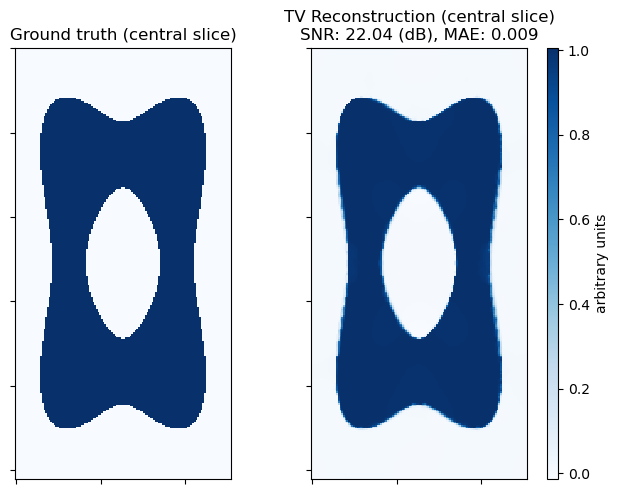

In [5]:
fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(7, 6))
plot.imview(
    tangle[32],
    title="Ground truth (central slice)",
    cmap=plot.cm.Blues,
    cbar=None,
    fig=fig,
    ax=ax[0],
)
plot.imview(
    tangle_recon[32],
    title="TV Reconstruction (central slice)\nSNR: %.2f (dB), MAE: %.3f"
    % (metric.snr(tangle, tangle_recon), metric.mae(tangle, tangle_recon)),
    cmap=plot.cm.Blues,
    fig=fig,
    ax=ax[1],
)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.2)
fig.colorbar(ax[1].get_images()[0], cax=cax, label="arbitrary units")
fig.show()